In [1]:
import os
from glob import glob

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras import datasets

import matplotlib.pyplot as plt
%matplotlib inline

### hyperparameter tunning

In [2]:
num_epochs = 10
batch_size = 32
learning_rate = 0.001
dropout_rate = 0.5
input_shape = (32,32,3)
num_classes = 10

### build model

In [3]:
inputs = layers.Input(input_shape)
net= layers.Conv2D(32,(3,3), padding= 'SAME')(inputs)
net = layers.Activation('relu')(net)
net= layers.Conv2D(32,(3,3), padding= 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size = (2,2))(net)
net = layers.Dropout(dropout_rate)(net)

net= layers.Conv2D(64,(3,3), padding= 'SAME')(net)
net = layers.Activation('relu')(net)
net= layers.Conv2D(64,(3,3), padding= 'SAME')(net)
net = layers.Activation('relu')(net)
net = layers.MaxPooling2D(pool_size = (2,2))(net)
net = layers.Dropout(dropout_rate)(net)

net = layers.Flatten()(net)
net = layers.Dense(512)(net)
net = layers.Activation('relu')(net)
net = layers.Dropout(dropout_rate)(net)
net = layers.Dense(num_classes)(net)
net = layers.Activation('softmax')(net)

model = tf.keras.Model(inputs= inputs, outputs= net, name = 'Basic_CNN')

In [26]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

### data preprocess

예시 label을 onehotencoding하기

In [5]:
os.listdir('cifar')

['labels.txt', 'test', 'train']

In [6]:
train_paths = glob('cifar/train/*.png')
test_paths = glob('cifar/test/*.png')

In [7]:
path = train_paths[0]
path

'cifar/train\\0_frog.png'

In [8]:
fname = tf.strings.split(path,'_')[-1]
fname

<tf.Tensor: shape=(), dtype=string, numpy=b'frog.png'>

In [9]:
lbl_name = tf.strings.regex_replace(fname, '.png', '')
lbl_name

<tf.Tensor: shape=(), dtype=string, numpy=b'frog'>

In [10]:
def get_class_name(path):
    fname = tf.strings.split(path,'_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    return lbl_name

In [11]:
class_names = [get_class_name(path) for path in train_paths]
class_names

[<tf.Tensor: shape=(), dtype=string, numpy=b'frog'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'automobile'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'frog'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'frog'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'ship'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'ship'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'cat'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'deer'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'frog'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'airplane'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'frog'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'truck'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'airplane'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'cat'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'frog'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'frog'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'dog'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'deer'>,
 <tf.Tensor: shape=(), dtype=strin

In [12]:
classes = tf.unique(class_names).y.numpy()
classes

array([b'frog', b'automobile', b'ship', b'cat', b'deer', b'airplane',
       b'truck', b'dog', b'bird', b'horse'], dtype=object)

In [13]:
one_hot_encoding = tf.cast(classes == get_class_name(path) , tf.uint8)


#### 함수로 만들기

In [14]:
def get_class_name(path):
    fname = tf.strings.split(path,'_')[-1]
    lbl_name = tf.strings.regex_replace(fname, '.png', '')
    return lbl_name

In [15]:
def onehot_encoding(label_names):
    onehot_encoding = tf.cast(classes == label_names,tf.uint8)
    return onehot_encoding

In [16]:
def read_dataset(path):
    # read image
    gfile = tf.io.read_file(path)
    image = tf.io.decode_image(gfile)
    
    #normalization
    image = tf.cast(image, tf.float32)/255
    
    # get onehot_encoding
    label_name = get_class_name(path)
    label = onehot_encoding(label_name)
    return image, label

### augmentation을 넣어주자

처음으로 등장

In [17]:
image, label = read_dataset(path)
image.shape, label.shape

(TensorShape([32, 32, 3]), TensorShape([10]))

In [18]:
def image_preprocess(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    # dataset은 입력이 2개여서 인자에 dummy를 추가한다
    return image, label

In [19]:
transformed, label = image_preprocess(image, label)
transformed.shape, label.shape

(TensorShape([32, 32, 3]), TensorShape([10]))

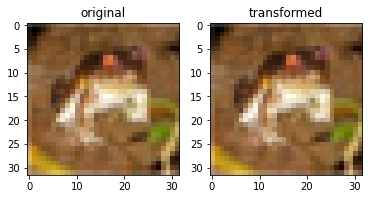

In [20]:
plt.subplot(121)
plt.title('original')
plt.imshow(image)
plt.subplot(122)
plt.title('transformed')
plt.imshow(transformed)

#### normalization도 필요함 

원래는 image_preprocess에 해야할거 같지만 test에도 적용이 필요하므로 양쪽 모두가 들어가는 read_dataset에서 normalization을 진행한다

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
train_dataset = train_dataset.map(read_dataset)
train_dataset = train_dataset.map(image_preprocess)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size = len(train_paths))
train_dataset = train_dataset.repeat()

In [22]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(read_dataset)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size = len(train_paths))
test_dataset = test_dataset.repeat()

### train

In [23]:
steps_per_epoch = len(train_paths)// batch_size
# steps_per_epochs = len(train_dataset)은 안댐

In [24]:
validation_steps = len(test_paths)//batch_size

In [27]:
model.fit_generator(
    train_dataset,
    steps_per_epoch = steps_per_epoch,
    validation_data = test_dataset,
    validation_steps = validation_steps,
    epochs = num_epochs)

Epoch 1/10
1562/1562 [==============================] - 178s 114ms/step - loss: 1.7387 - accuracy: 0.3466 - val_loss: 1.4351 - val_accuracy: 0.4651
Epoch 2/10
1562/1562 [==============================] - 180s 115ms/step - loss: 1.4367 - accuracy: 0.4717 - val_loss: 1.2749 - val_accuracy: 0.5368
Epoch 3/10
1562/1562 [==============================] - 180s 115ms/step - loss: 1.3298 - accuracy: 0.5162 - val_loss: 1.2075 - val_accuracy: 0.5557
Epoch 4/10
1562/1562 [==============================] - 180s 115ms/step - loss: 1.2602 - accuracy: 0.5460 - val_loss: 1.1825 - val_accuracy: 0.5677
Epoch 5/10
1562/1562 [==============================] - 181s 116ms/step - loss: 1.2081 - accuracy: 0.5645 - val_loss: 1.1425 - val_accuracy: 0.5831
Epoch 6/10
1562/1562 [==============================] - 180s 115ms/step - loss: 1.1685 - accuracy: 0.5809 - val_loss: 1.1340 - val_accuracy: 0.6006
Epoch 7/10
1562/1562 [==============================] - 182s 117ms/step - loss: 1.1329 - accuracy: 0.5947 - val_